## SimFOL Computation

In [3]:
from typing import Callable, Any, Set, Tuple, List, FrozenSet, Dict
from functools import lru_cache
from sentence_transformers import SentenceTransformer, util
import numpy as np

# --- SBERT Helpers ---
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")
_seen_debugs = {
    level: set() for level in [
        "literal_flat", "literal_weighted",
        "clause_flat", "clause_weighted",
        "formula"]
}
_debug_summary = {
    level: [] for level in [
        "literal_flat", "literal_weighted",
        "clause_flat", "clause_weighted",
        "formula"]
}

@lru_cache(maxsize=2048)
def get_embedding(text: str):
    return sbert_model.encode(text, convert_to_tensor=True)

def normalize_str(s: str) -> str:
    return s.lower().replace("_", " ").replace("(", "").replace(")", "").replace("not ", "¬").strip()

def sim_sbert_normalized(a: str, b: str) -> float:
    a_norm, b_norm = normalize_str(a), normalize_str(b)
    return util.cos_sim(get_embedding(a_norm), get_embedding(b_norm)).item()

# Charger un modèle SBERT pré-entraîné
model = SentenceTransformer('all-mpnet-base-v2')  # rapide et performant 
def sim_sbert_normalized2(a: str, b: str) -> float:
    a_norm, b_norm = normalize_str(a), normalize_str(b)
    embedding1 = model.encode(a_norm, convert_to_tensor=True)
    embedding2 = model.encode(b_norm, convert_to_tensor=True)
    return util.cos_sim(embedding1, embedding2).item()

def agg_max(scores: List[float]) -> float:
    return max(scores) if scores else 0.0

def agg_avg(scores: List[float]) -> float:
    return sum(scores) / len(scores) if scores else 0.0

def agg_softmax(scores: List[float], temperature: float = 2) -> float:
    if not scores:
        return 0.0
    exp_scores = [np.exp(s * temperature) for s in scores]
    softmax_weights = [e / sum(exp_scores) for e in exp_scores]
    return sum(w * s for w, s in zip(softmax_weights, scores))


def pointwise_similarity_flat(
    args1: List[str],
    args2: List[str],
    simC: Callable[[str, str], float],
    positional_weight: float = 0.8,
    unordered_weight: float = 0.2,
    diff: float = 0
) -> float:
    if not args1 or not args2:
        return 0.0

    min_len = min(len(args1), len(args2))
    sim_pos, total_weight_pos = 0.0, 0.0
    for i in range(min_len):
        a1, a2 = args1[i], args2[i]
        sim = simC(a1, a2)
        sim_pos += sim
        total_weight_pos += 1
    sim_pos = sim_pos / (total_weight_pos + diff) if total_weight_pos > 0 else 0.0

    
    sim_unordered, total_weight_unordered = 0.0, 0.0

    for a1 in args1:
        best_sim, best_imp = 0.0, 0.0
        for a2 in args2:
            sim = simC(a1, a2)
            importance = 1
            if sim > best_sim:
                best_sim, best_imp = sim, importance
        sim_unordered += best_sim * best_imp
        total_weight_unordered += best_imp

    for a2 in args2:
        best_sim, best_imp = 0.0, 0.0
        for a1 in args1:
            sim = simC(a2, a1)
            importance = 1
            if sim > best_sim:
                best_sim, best_imp = sim, importance
        sim_unordered += best_sim * best_imp
        total_weight_unordered += best_imp

    sim_unordered = sim_unordered / (total_weight_unordered + diff) if total_weight_unordered > 0 else 0.0
        
    return positional_weight * sim_pos + unordered_weight * sim_unordered


def pointwise_similarity_weighted(
    args1: List[str],
    args2: List[str],
    simC: Callable[[str, str], float],
    weights1: Dict[str, float],
    weights2: Dict[str, float],
    positional_weight: float = 0.8,
    unordered_weight: float = 0.2,
    diff: float = 0
) -> float:
    if not args1 or not args2:
        return 0.0

    min_len = min(len(args1), len(args2))
    sim_pos, total_weight_pos = 0.0, 0.0
    for i in range(min_len):
        a1, a2 = args1[i], args2[i]
        sim = simC(a1, a2)
        w1 = weights1.get(a1, 0.0)
        w2 = weights2.get(a2, 0.0)
        importance = w1 * w2
        sim_pos += importance * sim
        total_weight_pos += importance
    sim_pos = sim_pos / (total_weight_pos + diff) if total_weight_pos > 0 else 0.0

    
    sim_unordered, total_weight_unordered = 0.0, 0.0

    for a1 in args1:
        w1 = weights1.get(a1, 0.0)
        best_sim, best_imp = 0.0, 0.0
        for a2 in args2:
            w2 = weights2.get(a2, 0.0)
            sim = simC(a1, a2)
            importance = w1 * w2
            if sim > best_sim:
                best_sim, best_imp = sim, importance
        sim_unordered += best_sim * best_imp
        total_weight_unordered += best_imp

    for a2 in args2:
        w2 = weights2.get(a2, 0.0)
        best_sim, best_imp = 0.0, 0.0
        for a1 in args1:
            w1 = weights1.get(a1, 0.0)
            sim = simC(a2, a1)
            importance = w2 * w1
            if sim > best_sim:
                best_sim, best_imp = sim, importance
        sim_unordered += best_sim * best_imp
        total_weight_unordered += best_imp

    sim_unordered = sim_unordered / (total_weight_unordered + diff) if total_weight_unordered > 0 else 0.0
        
    return positional_weight * sim_pos + unordered_weight * sim_unordered

def safe_sort_clause(c: FrozenSet[Tuple[str, Tuple[str, ...]]]) -> List:
    return sorted(list(c), key=lambda lit: (lit[0], lit[1]))

def record_debug(level: str, key: frozenset, entry: Tuple):
    if key not in _seen_debugs[level]:
        _seen_debugs[level].add(key)
        _debug_summary[level].append(entry)

def simLiteral_flat(
    obj1: Tuple[str, Tuple[str, ...]],
    obj2: Tuple[str, Tuple[str, ...]],
    debug: dict = None,
    diff: float = 0.0
) -> float:
    pred1, args1 = obj1
    pred2, args2 = obj2

    sim_pred = sim_sbert_normalized(pred1, pred2)
    sim_args = pointwise_similarity_flat(
        list(args1), list(args2), sim_sbert_normalized,
        diff=diff
    )

    score = 0.5 * sim_pred + 0.5 * sim_args

    if debug and debug.get("literal", False):
        key = frozenset({obj1, obj2})
        if key not in _seen_debugs["literal_flat"]:
            _seen_debugs["literal_flat"].add(key)
            canonical = tuple(sorted([obj1, obj2]))
            _debug_summary["literal_flat"].append((*canonical, sim_pred, sim_args, score))

    return score


def simLiteral(
    obj1: Tuple[str, Tuple[str, ...]],
    obj2: Tuple[str, Tuple[str, ...]],
    predicate_weights1: Dict[str, float],
    predicate_weights2: Dict[str, float],
    constant_weights1: Dict[str, float],
    constant_weights2: Dict[str, float],
    debug: dict = None,
    diff: float = 0.0
) -> float:
    pred1, args1 = obj1
    pred2, args2 = obj2

    sim_pred = sim_sbert_normalized(pred1, pred2)
    imp_pred = predicate_weights1.get(pred1, 0.0) * predicate_weights2.get(pred2, 0.0)
    num = sim_pred * imp_pred
    denom = imp_pred

    sim_args = pointwise_similarity_weighted(
        list(args1), list(args2), sim_sbert_normalized,
        weights1={k: 1.0 for k in args1},
        weights2={k: 1.0 for k in args2},
        diff=diff
    )

    total_weight_pos = 0
    min_len = min(len(args1), len(args2))
    for i in range(min_len):
        a1, a2 = args1[i], args2[i]
        w1 = constant_weights1.get(a1, 0.0)
        w2 = constant_weights2.get(a2, 0.0)
        importance = w1 * w2
        total_weight_pos += importance

    total_weight_unordered = 0.0

    for a1 in args1:
        w1 = constant_weights1.get(a1, 0.0)
        best_sim, best_imp = 0.0, 0.0
        for a2 in args2:
            w2 = constant_weights2.get(a2, 0.0)
            sim = sim_sbert_normalized(a1, a2)
            importance = w1 * w2
            if sim > best_sim:
                best_sim, best_imp = sim, importance
        total_weight_unordered += best_imp

    for a2 in args2:
        w2 = constant_weights2.get(a2, 0.0)
        best_sim, best_imp = 0.0, 0.0
        for a1 in args1:
            w1 = constant_weights1.get(a1, 0.0)
            sim = sim_sbert_normalized(a2, a1)
            importance = w2 * w1
            if sim > best_sim:
                best_sim, best_imp = sim, importance
        total_weight_unordered += best_imp

    total_weight_param = (0.8 * total_weight_pos) + (0.2 * total_weight_unordered)

    num += sim_args * total_weight_param
    denom += total_weight_param

    score = num / (denom + diff) if denom > 0 else 0.0

    if debug and debug.get("literal", False):
        key = frozenset({obj1, obj2})
        canonical = tuple(sorted([obj1, obj2]))
        pred_weight1 = predicate_weights1.get(pred1, 0.0)
        pred_weight2 = predicate_weights2.get(pred2, 0.0)
        args_weights = [(a1, a2, constant_weights1.get(a1, 0.0), constant_weights2.get(a2, 0.0)) for a1 in args1 for a2 in args2]
        record_debug("literal_weighted", key, (*canonical, sim_pred, sim_args, score, pred_weight1, pred_weight2, args_weights))

    return score

def generalized_tversky_similarity(
    X: Set[Any],
    Y: Set[Any],
    sim: Callable[[Any, Any], float],
    alpha: float = 0.5,
    beta: float = 0.5,
    p: float = 1.0,
    agg: Callable[[List[float]], float] = max,
    debug: dict = None,
    debug_level: str = ""
) -> float:
    if not X or not Y:
        return 0.0

    def membership(x, Y):
        sim_values = [sim(x, y) ** p for y in Y]
        return agg(sim_values), sim_values

    match_X, all_sim_X = [], []
    for x in X:
        val, sims = membership(x, Y)
        match_X.append(val)
        all_sim_X.append((x, Y, sims))

    match_Y, all_sim_Y = [], []
    for y in Y:
        val, sims = membership(y, X)
        match_Y.append(val)
        all_sim_Y.append((y, X, sims))

    A = (sum(match_X) + sum(match_Y)) / 2
    B = sum(1 - s for s in match_X)
    C = sum(1 - s for s in match_Y)
    denom = A + alpha * B + beta * C
    score = A / denom if denom > 0 else 0.0

    # Debug summary logging
    if debug and debug.get(debug_level, False):
        for x, Y_group, sims in all_sim_X:
            for y, s in zip(Y_group, sims):
                _debug_summary[debug_level].append(("literal_pair", x, y, s ** (1/p)))

        for y, X_group, sims in all_sim_Y:
            for x, s in zip(X_group, sims):
                _debug_summary[debug_level].append(("literal_pair", y, x, s ** (1/p)))

        _debug_summary[debug_level].append(("TOTAL", A, B, C, score))

    return score

    
def simFormulaSet(
    F1: Set[FrozenSet[Tuple[str, Tuple[str, ...]]]],
    F2: Set[FrozenSet[Tuple[str, Tuple[str, ...]]]],
    clause_weights1: Dict[FrozenSet[Tuple[str, Tuple[str, ...]]], float],
    clause_weights2: Dict[FrozenSet[Tuple[str, Tuple[str, ...]]], float],
    predicate_weights1: Dict[str, float],
    predicate_weights2: Dict[str, float],
    constant_weights1: Dict[str, float],
    constant_weights2: Dict[str, float],
    params: dict = None,
    debug: dict = None
) -> Tuple[float, Dict[str, List[Any]]]:
    for level in _seen_debugs:
        _seen_debugs[level].clear()
    for level in _debug_summary:
        _debug_summary[level].clear()

    sum_preds = sum(predicate_weights1.values()) + sum(predicate_weights2.values())
    sum_consts = sum(constant_weights1.values()) + sum(constant_weights2.values())
    diff = 2 - sum_preds - sum_consts
    epsilon = 1e-4
    diff = 0.0 if abs(diff) < epsilon else diff

    all_clauses1 = sorted(F1, key=safe_sort_clause)
    all_clauses2 = sorted(F2, key=safe_sort_clause)

    # --- Literal flat similarities (for debug only) ---
    if debug and debug.get("literal", False):
        for c1 in all_clauses1:
            for c2 in all_clauses2:
                for lit1 in c1:
                    for lit2 in c2:
                        _ = simLiteral_flat(lit1, lit2, debug=debug, diff=diff)

    # --- Flat clause similarities ---
    flat_similarities = {}
    for c1 in all_clauses1:
        for c2 in all_clauses2:
            sim = generalized_tversky_similarity(
                c1, c2,
                sim=lambda l1, l2: simLiteral_flat(l1, l2, debug=debug, diff=diff),
                alpha=0.5, beta=0.5, p=1.0, agg=agg_avg,
                debug=debug,
                debug_level="clause_flat"
            )
            _debug_summary["clause_flat"].append(("clause_pair_score", c1, c2, sim))
            flat_similarities[(c1, c2)] = sim

    # --- Best clause matches ---
    best_matches = []
    for c1 in all_clauses1:
        best_c2 = max(all_clauses2, key=lambda c2: flat_similarities[(c1, c2)])
        best_matches.append((c1, best_c2, flat_similarities[(c1, best_c2)]))
    for c2 in all_clauses2:
        best_c1 = max(all_clauses1, key=lambda c1: flat_similarities[(c1, c2)])
        best_matches.append((best_c1, c2, flat_similarities[(best_c1, c2)]))

    # --- Weighted clause similarities on best matches ---
    weighted_scores = []
    for (c1, c2, _) in best_matches:
        sim = generalized_tversky_similarity(
            c1, c2,
            sim=lambda l1, l2: simLiteral(
                l1, l2,
                predicate_weights1=predicate_weights1,
                predicate_weights2=predicate_weights2,
                constant_weights1=constant_weights1,
                constant_weights2=constant_weights2,
                debug=debug,
                diff=diff
            ),
            alpha=params.get("clause", {}).get("alpha", 0.5),
            beta=params.get("clause", {}).get("beta", 0.5),
            p=params.get("clause", {}).get("p", 1.0),
            agg=params.get("clause", {}).get("agg", agg_avg),
            debug=debug,
            debug_level="clause_weighted"
        )
        w1 = clause_weights1.get(c1, 1.0)
        w2 = clause_weights2.get(c2, 1.0)
        _debug_summary["clause_weighted"].append(("clause_pair_score", c1, c2, sim, w1, w2, (w1 + w2) / 2))
        weighted_scores.append((sim, (w1 + w2) / 2))

    # --- Final weighted score ---
    total_weight = sum(w for _, w in weighted_scores)
    final_score = sum(s * w for s, w in weighted_scores) / total_weight if total_weight > 0 else 0.0

    _debug_summary["formula"].append(("TOTAL", 0, 0, 0, final_score))
    _debug_summary["formula"].extend([("formula_pair", c1, c2, flat_sim) for (c1, c2, flat_sim) in best_matches])

    # --- Literal weighted similarities (after best match) ---
    if debug and debug.get("literal", False):
        for c1 in all_clauses1:
            for c2 in all_clauses2:
                for lit1 in c1:
                    for lit2 in c2:
                        _ = simLiteral(
                            lit1, lit2,
                            predicate_weights1=predicate_weights1,
                            predicate_weights2=predicate_weights2,
                            constant_weights1=constant_weights1,
                            constant_weights2=constant_weights2,
                            debug=debug,
                            diff=diff
                        )

    return final_score, _debug_summary


## SimFOL Summary

In [4]:
def summarize_debug_output(summary: dict, debug: dict = None, top_n: int = 10):
    print("\n🔍 SUMMARY OF SIMILARITY COMPARISON\n")

    # 1. Literal FLAT
    if debug.get("literal", False):
        literals = summary.get("literal_flat", [])
        literals.sort(key=lambda x: x[-1], reverse=True)
        print("📌 LITERAL LEVEL (Flat)")
        print(f"  → Total literal pairs (flat): {len(literals)}")
        for idx, (lit1, lit2, sim_pred, sim_args, score) in enumerate(literals[:top_n], 1):
            print(f"    {idx}. {lit1} ⇄ {lit2}")
            print(f"       • predicate similarity: {sim_pred:.3f}")
            print(f"       • parameter similarity : {sim_args:.3f}")
            print(f"       • literal similarity  : {score:.3f}")

    # 2. Literal WEIGHTED
    literals_w = summary.get("literal_weighted", [])
    literals_w.sort(key=lambda x: x[5], reverse=True)  # sort by final similarity score
    if literals_w:
        print("\n📌 LITERAL LEVEL (Weighted)")
        print(f"  → Total literal pairs (weighted): {len(literals_w)}")
        for idx, (lit1, lit2, sim_pred, sim_args, score, pred_w1, pred_w2, args_weights) in enumerate(literals_w[:top_n], 1):
            print(f"\n  {idx}. {lit1} ⇄ {lit2}")
            print(f"     • predicate similarity        : {sim_pred:.3f}")
            print(f"     • parameter similarity         : {sim_args:.3f}")
            print(f"     • final literal similarity    : {score:.3f}")

    # 3. Clause FLAT
    clauses = summary.get("clause_flat", [])
    clauses.sort(key=lambda x: x[-1], reverse=True)
    if clauses:
        print("\n📌 CLAUSE LEVEL (Flat)")
        print(f"  → Total clause pairs compared (flat): {len(clauses)}")
        for idx, (_, clause1, clause2, score) in enumerate(clauses[:top_n], 1):
            print(f"    {idx}. Clause 1: {clause1}")
            print(f"         Clause 2: {clause2}")
            print(f"         → Clause similarity: {score:.3f}")

    # 4. Clause WEIGHTED
    clauses_w = summary.get("clause_weighted", [])
    if clauses_w:
        print("\n📌 CLAUSE LEVEL (Weighted)")
        print(f"  → Total clause pairs (weighted best matches): {len(clauses_w)}")

        clause_scores = []
        for (_, clause1, clause2, score, w1, w2, mean_w) in clauses_w:
            contribution = score * mean_w
            clause_scores.append((score, w1, w2, mean_w, contribution, clause1, clause2))

        clause_scores.sort(key=lambda x: x[4], reverse=True)

        for idx, (score, w1, w2, mean_w, contribution, clause1, clause2) in enumerate(clause_scores[:top_n], 1):
            print(f"\n  {idx}. Clause pair:")
            print(f"       Clause 1: {clause1}")
            print(f"       Clause 2: {clause2}")
            print(f"       → Weighted clause similarity: {score:.3f}")
            print(f"         Clause weights = {w1:.3f} (F1), {w2:.3f} (F2)")
            print(f"         Mean weight     = {mean_w:.3f}")
            print(f"         Contribution    = {score:.3f} × {mean_w:.3f} = {contribution:.3f}")

    # 5. FORMULA
    formulas = summary.get("formula", [])
    totals = [e for e in formulas if isinstance(e, tuple) and e[0] == "TOTAL"]
    for (_, a, b, c, score) in totals:
        print("\n📌 FORMULA LEVEL")
        print("  → Final formula similarity score (weighted over best clause matches):\n")

        if clauses_w:
            total_contr = sum(c[4] for c in clause_scores)
            total_weight = sum(c[3] for c in clause_scores)
            print(f"    → Weighted average score:")
            print(f"         = ({' + '.join(f'{c[4]:.3f}' for c in clause_scores[:top_n])}) / ({' + '.join(f'{c[3]:.3f}' for c in clause_scores[:top_n])})")
            print(f"         = {score:.3f}")


## SimFOL Plot (Proportion Importance Weights)

In [5]:
import matplotlib.pyplot as plt
from typing import FrozenSet, Tuple

def format_clause(clause: FrozenSet[Tuple[str, Tuple[str, ...]]]) -> str:
    """
    Formats a CNF clause (as a frozenset of literals) into a readable string.
    Example: frozenset({("Teasing", ("Dog", "Monkey"))}) → Teasing(Dog,Monkey)
    """
    literals = []
    for pred, args in clause:
        args_str = ",".join(args)
        literals.append(f"{pred}({args_str})")
    return " ∨ ".join(literals)

def plot_weighted_clause_contributions(summary: dict, x_labels: str = "text"):
    """
    Displays a plot showing clause pair similarities and their normalized contribution
    to the final similarity score between two formulae.

    Args:
        summary (dict): summary dictionary returned by simFormulaSet
        x_labels (str): "text" to display CNF clauses, "index" to display numeric indices
    """
    clause_pairs = summary.get("clause_weighted", [])
    formula_data = summary.get("formula", [])
    
    if not clause_pairs:
        print("No clause-weighted data to plot.")
        return

    # Retrieve final formula similarity score
    final_score = None
    for item in formula_data:
        if isinstance(item, tuple) and item[0] == "TOTAL":
            final_score = item[-1]
            break

    scores, mean_weights, labels = [], [], []

    for idx, entry in enumerate(clause_pairs, 1):
        _, c1, c2, sim, w1, w2, mean_w = entry
        scores.append(sim)
        mean_weights.append(mean_w)

        if x_labels == "text":
            label = f"{format_clause(c1)} ⇄ {format_clause(c2)}"
        else:
            label = f"{idx}"
        labels.append(label)

    # Compute the relative importance of each clause pair
    total_weight = sum(mean_weights)
    if total_weight > 0:
        normalized_weights = [w / total_weight for w in mean_weights]
    else:
        normalized_weights = [0 for _ in mean_weights]

    fig, ax1 = plt.subplots(figsize=(12, 6))
    x_pos = list(range(len(labels)))

    # Blue bars: Similarity
    ax1.bar(x_pos, scores, color="skyblue", label="Clause Similarity")
    ax1.set_ylabel("Similarity Score", color="skyblue")
    ax1.set_ylim(0, 1.05)
    ax1.set_xticks(x_pos)

    if x_labels == "text":
        ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize=8)
    else:
        ax1.set_xticklabels(labels)

    # Red curve : normalized contributions
    ax2 = ax1.twinx()
    ax2.plot(x_pos, normalized_weights, "o--", color="red", label="Proportion of Importance")
    ax2.set_ylabel("Proportion of Importance", color="red")
    ax2.set_ylim(0, max(normalized_weights) * 1.1 if normalized_weights else 1)

    # Green Line : final score
    if final_score is not None:
        ax1.axhline(y=final_score, color="green", linewidth=3, linestyle="--", label=f"Formulae Similarity = {final_score:.3f}")

    title_mode = "Textual CNF Labels" if x_labels == "text" else "Indexed Clause Pairs"
    plt.title(f"Clause Similarity and Proportion of Importance ({title_mode})")
    fig.tight_layout()
    plt.grid(True, axis="y", linestyle="--", alpha=0.5)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    plt.show()



## Sentence Similarity Comparison between SimFOL, SimBERT, S3BERT, ChatGPT


🔷 FINAL SIMILARITY SCORE: 0.628

🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL LEVEL (Flat)
  → Total literal pairs (flat): 8
    1. ('AtLocation', ('Dog', 'Zoo')) ⇄ ('AtLocation', ('Dog', 'Zoo'))
       • predicate similarity: 1.000
       • parameter similarity : 1.000
       • literal similarity  : 1.000
    2. ('AtLocation', ('Monkey', 'Zoo')) ⇄ ('AtLocation', ('Monkey', 'Zoo'))
       • predicate similarity: 1.000
       • parameter similarity : 1.000
       • literal similarity  : 1.000
    3. ('AtLocation', ('Dog', 'Zoo')) ⇄ ('AtLocation', ('Monkey', 'Zoo'))
       • predicate similarity: 1.000
       • parameter similarity : 0.735
       • literal similarity  : 0.868
    4. ('Teasing', ('Dog', 'Monkey')) ⇄ ('Teasing', ('Monkey', 'Dog'))
       • predicate similarity: 1.000
       • parameter similarity : 0.573
       • literal similarity  : 0.786
    5. ('AtLocation', ('Dog', 'Zoo')) ⇄ ('Teasing', ('Dog', 'Monkey'))
       • predicate similarity: 0.146
       • parameter simil

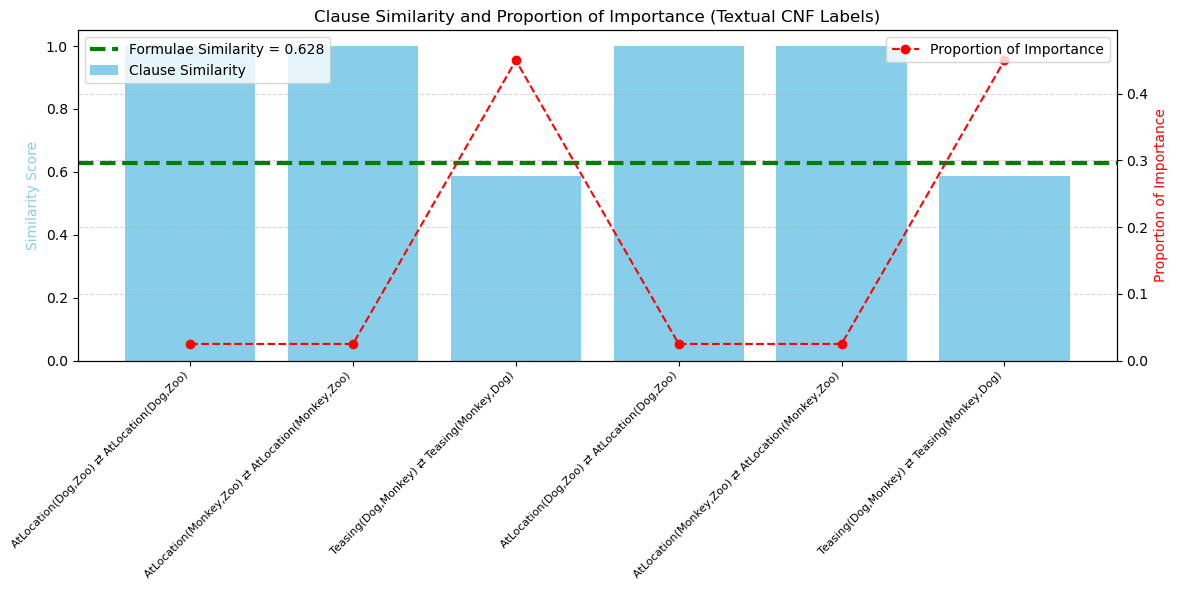

In [11]:
weighted_T1 = {
    "instances": frozenset({
        frozenset({("Teasing", ("Dog", "Monkey"))}),
        frozenset({("AtLocation", ("Dog", "Zoo"))}),
        frozenset({("AtLocation", ("Monkey", "Zoo"))}),
    }),
    "clause_weights": {
        frozenset({("Teasing", ("Dog", "Monkey"))}): 0.9,
        frozenset({("AtLocation", ("Dog", "Zoo"))}): 0.05,
        frozenset({("AtLocation", ("Monkey", "Zoo"))}): 0.05,
    },
    "predicate_weights": {
        "Teasing": 0.1,
        "AtLocation": 0.1,
    },
    "constant_weights": {
        "Dog": 0.35,
        "Monkey": 0.35,
        "Zoo": 0.1
    }
}

weighted_T2 = {
    "instances": frozenset({
        frozenset({("Teasing", ("Monkey", "Dog"))}),
        frozenset({("AtLocation", ("Dog", "Zoo"))}),
        frozenset({("AtLocation", ("Monkey", "Zoo"))}),
    }),
    "clause_weights": {
        frozenset({("Teasing", ("Monkey", "Dog"))}): 0.9,
        frozenset({("AtLocation", ("Dog", "Zoo"))}): 0.05,
        frozenset({("AtLocation", ("Monkey", "Zoo"))}): 0.05,
    },
    "predicate_weights": {
        "Teasing": 0.1,
        "AtLocation": 0.1,
    },
    "constant_weights": {
        "Dog": 0.35,
        "Monkey": 0.35,
        "Zoo": 0.1
    }
}

# --- Parameters ---
params = {
    "clause": {
        "alpha": 0.5,
        "beta": 0.5,
        "p": 1,
        "agg": agg_avg
    },
    "formula": {
        "alpha": 0.5,
        "beta": 0.5,
        "p": 1,
        "agg": agg_max
    }
}

# --- Flags of debug ---
debug_flags = {
    "literal": True,
    "clause": True,
    "formula": True
}

# --- Call of the similarity function ---
score, summary = simFormulaSet(
    F1=weighted_T1["instances"],
    F2=weighted_T2["instances"],
    clause_weights1=weighted_T1["clause_weights"],
    clause_weights2=weighted_T2["clause_weights"],
    predicate_weights1=weighted_T1["predicate_weights"],
    predicate_weights2=weighted_T2["predicate_weights"],
    constant_weights1=weighted_T1["constant_weights"],
    constant_weights2=weighted_T2["constant_weights"],
    params=params,
    debug=debug_flags
)

print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")
# --- Display of the summary ---
debug_flags["clause_weights1"] = weighted_T1["clause_weights"]
debug_flags["clause_weights2"] = weighted_T2["clause_weights"]

summarize_debug_output(summary, debug=debug_flags, top_n=9)
plot_weighted_clause_contributions(summary, x_labels="text") #x_labels="index"



In [14]:
from sentence_transformers import SentenceTransformer, util

# Load a pre-trained SBERT model
sbert_model = SentenceTransformer("all-MiniLM-L6-v2") # fast and efficient

T1 = "A dog is teasing a monkey at the zoo"
T2 = "A monkey is teasing a dog at the zoo"

# Encode sentences into vectors
embedding1 = sbert_model.encode(T1, convert_to_tensor=True)
embedding2 = sbert_model.encode(T2, convert_to_tensor=True)

# Compute the cosinus similarity
similarity_score = util.pytorch_cos_sim(embedding1, embedding2)

# Display
print(f"Similarity between \"{T1}\" and \"{T2}\": {similarity_score.item():.3f}")

Similarity between "A dog is teasing a monkey at the zoo" and "A monkey is teasing a dog at the zoo": 0.985


### Sentences:
T1 = "A dog is teasing a monkey at the zoo"

T2 = "A monkey is teasing a dog at the zoo"

### Similarity between T1, T2:
- SBERT = 0.985
- S3BERT = 0.99
- ChatGPT-o4 = 0.4  ("Prompt: I will give you two sentences, return their similarity between 0 and 1.")
- SimFOL = 0.628
- Human = 0.63

## Similarity between CNF FOL Arguments

🔹 Argument 1 (Based on T1)

Premise 1: A dog is teasing a monkey at the zoo.

Premise 2: Teasing usually indicates dominance or play behavior.

Teasing(Dog, Monkey)
AtLocation(Dog, Zoo)
AtLocation(Monkey, Zoo)
¬Teasing(x, y) ∨ Dominant(x) ∨ Playful(x)

Claim: The dog is likely exhibiting dominant or playful behavior toward the monkey.

Dominant(Dog) ∨ Playful(Dog)



🔹 Argument 2 (Comparative, Based on T1 and T2)

Premise 1: A dog is teasing a monkey at the zoo.

Premise 2: A monkey is teasing a dog at the zoo.

Premise 3: Teasing is mutual, suggesting a playful relationship.

Teasing(Dog, Monkey)
Teasing(Monkey, Dog)
AtLocation(Dog, Zoo)
AtLocation(Monkey, Zoo)
¬Teasing(x, y) ∨ ¬Teasing(y, x) ∨ PlayfulInteraction(x, y)

Claim: The dog and the monkey have a playful interaction.

PlayfulInteraction(Dog, Monkey)


🔹 Argument 3 (Contradiction/Disagreement)

Premise 1: A dog is teasing a monkey at the zoo.

Premise 2: A monkey is teasing a dog at the zoo.

Premise 3: Mutual teasing between animals often reflects a social conflict.

Teasing(Dog, Monkey)
Teasing(Monkey, Dog)
AtLocation(Dog, Zoo)
AtLocation(Monkey, Zoo)
¬Teasing(x, y) ∨ ¬Teasing(y, x) ∨ SocialConflict(x, y)

Claim: The dog and monkey may be engaged in a social conflict.

SocialConflict(Dog, Monkey)

## DATA Arguments 1,2,3

In [15]:
######## Argument 1 vs : 2 and 3
# Premises
weighted_arg1_vs_arg2_premises = {
    "instances": frozenset({
        frozenset({("Teasing", ("Dog", "Monkey"))}),
        frozenset({("AtLocation", ("Dog", "Zoo"))}),
        frozenset({("AtLocation", ("Monkey", "Zoo"))}),
        frozenset({("¬Teasing", ("x", "y")), ("Dominant", ("x",)), ("Playful", ("x",))}),
    }),
    "clause_weights": {
        frozenset({("Teasing", ("Dog", "Monkey"))}): 0.4,
        frozenset({("AtLocation", ("Dog", "Zoo"))}): 0.1,
        frozenset({("AtLocation", ("Monkey", "Zoo"))}): 0.1,
        frozenset({("¬Teasing", ("x", "y")), ("Dominant", ("x",)), ("Playful", ("x",))}): 0.4,
    },
    "predicate_weights": {
        "Teasing": 0.05,
        "¬Teasing": 0.05,
        "AtLocation": 0.05,
        "Dominant": 0.2,
        "Playful": 0.2,
    },
    "constant_weights": {
        "Dog": 0.2,
        "Monkey": 0.2,
        "Zoo": 0.05,
        "x": 0,
        "y": 0
    }
}

weighted_arg1_vs_arg3_premises = {
    "instances": frozenset({
        frozenset({("Teasing", ("Dog", "Monkey"))}),
        frozenset({("AtLocation", ("Dog", "Zoo"))}),
        frozenset({("AtLocation", ("Monkey", "Zoo"))}),
        frozenset({("¬Teasing", ("x", "y")), ("Dominant", ("x",)), ("Playful", ("x",))}),
    }),
    "clause_weights": {
        frozenset({("Teasing", ("Dog", "Monkey"))}): 0.4,
        frozenset({("AtLocation", ("Dog", "Zoo"))}): 0.1,
        frozenset({("AtLocation", ("Monkey", "Zoo"))}): 0.1,
        frozenset({("¬Teasing", ("x", "y")), ("Dominant", ("x",)), ("Playful", ("x",))}): 0.4,
    },
    "predicate_weights": {
        "Teasing": 0.05,
        "¬Teasing": 0.05,
        "AtLocation": 0.05,
        "Dominant": 0.2,
        "Playful": 0.2,
    },
    "constant_weights": {
        "Dog": 0.2,
        "Monkey": 0.2,
        "Zoo": 0.05,
        "x": 0,
        "y": 0
    }
}

# Claim
weighted_arg1_vs_arg2_claim = {
    "instances": frozenset({
        frozenset({("Dominant", ("Dog",)), ("Playful", ("Dog",))}),
    }),
    "clause_weights": {
        frozenset({("Dominant", ("Dog",)), ("Playful", ("Dog",))}): 1.0
    },
    "predicate_weights": {
        "Dominant": 0.35,
        "Playful": 0.35
    },
    "constant_weights": {
        "Dog": 0.3
    }
}

weighted_arg1_vs_arg3_claim = {
    "instances": frozenset({
        frozenset({("Dominant", ("Dog",)), ("Playful", ("Dog",))}),
    }),
    "clause_weights": {
        frozenset({("Dominant", ("Dog",)), ("Playful", ("Dog",))}): 1.0
    },
    "predicate_weights": {
        "Dominant": 0.35,
        "Playful": 0.35
    },
    "constant_weights": {
        "Dog": 0.3
    }
}

# Argument 2 vs : 1 and 3
# Premises
weighted_arg2_vs_arg1_premises = {
    "instances": frozenset({
        frozenset({("Teasing", ("Dog", "Monkey"))}),
        frozenset({("Teasing", ("Monkey", "Dog"))}),
        frozenset({("AtLocation", ("Dog", "Zoo"))}),
        frozenset({("AtLocation", ("Monkey", "Zoo"))}),
        frozenset({("¬Teasing", ("x", "y")), ("¬Teasing", ("y", "x")), ("PlayfulInteraction", ("x", "y"))}),
    }),
    "clause_weights": {
        frozenset({("Teasing", ("Dog", "Monkey"))}): 0.1,
        frozenset({("Teasing", ("Monkey", "Dog"))}): 0.4,
        frozenset({("AtLocation", ("Dog", "Zoo"))}): 0.05,
        frozenset({("AtLocation", ("Monkey", "Zoo"))}): 0.05,
        frozenset({("¬Teasing", ("x", "y")), ("¬Teasing", ("y", "x")), ("PlayfulInteraction", ("x", "y"))}): 0.4,
    },
    "predicate_weights": {
        "Teasing": 0.05,
        "¬Teasing": 0.05,
        "AtLocation": 0.05,
        "PlayfulInteraction": 0.4,
    },
    "constant_weights": {
        "Dog": 0.2,
        "Monkey": 0.2,
        "Zoo": 0.05,
        "x": 0,
        "y": 0
    }
}

weighted_arg2_vs_arg3_premises = {
    "instances": frozenset({
        frozenset({("Teasing", ("Dog", "Monkey"))}),
        frozenset({("Teasing", ("Monkey", "Dog"))}),
        frozenset({("AtLocation", ("Dog", "Zoo"))}),
        frozenset({("AtLocation", ("Monkey", "Zoo"))}),
        frozenset({("¬Teasing", ("x", "y")), ("¬Teasing", ("y", "x")), ("PlayfulInteraction", ("x", "y"))}),
    }),
    "clause_weights": {
        frozenset({("Teasing", ("Dog", "Monkey"))}): 0.3,
        frozenset({("Teasing", ("Monkey", "Dog"))}): 0.3,
        frozenset({("AtLocation", ("Dog", "Zoo"))}): 0.05,
        frozenset({("AtLocation", ("Monkey", "Zoo"))}): 0.05,
        frozenset({("¬Teasing", ("x", "y")), ("¬Teasing", ("y", "x")), ("PlayfulInteraction", ("x", "y"))}): 0.3,
    },
    "predicate_weights": {
        "Teasing": 0.05,
        "¬Teasing": 0.05,
        "AtLocation": 0.05,
        "PlayfulInteraction": 0.4,
    },
    "constant_weights": {
        "Dog": 0.2,
        "Monkey": 0.2,
        "Zoo": 0.05,
        "x": 0,
        "y": 0
    }
}

# Claim
weighted_arg2_vs_arg1_claim = {
    "instances": frozenset({
        frozenset({("PlayfulInteraction", ("Dog", "Monkey"))}),
    }),
    "clause_weights": {
        frozenset({("PlayfulInteraction", ("Dog", "Monkey"))}): 1.0
    },
    "predicate_weights": {
        "PlayfulInteraction": 0.7
    },
    "constant_weights": {
        "Dog": 0.15,
        "Monkey": 0.15
    }
}

weighted_arg2_vs_arg3_claim = {
    "instances": frozenset({
        frozenset({("PlayfulInteraction", ("Dog", "Monkey"))}),
    }),
    "clause_weights": {
        frozenset({("PlayfulInteraction", ("Dog", "Monkey"))}): 1.0
    },
    "predicate_weights": {
        "PlayfulInteraction": 0.7
    },
    "constant_weights": {
        "Dog": 0.15,
        "Monkey": 0.15
    }
}

# Argument 3 vs : 1 and 2
# Premises
weighted_arg3_vs_arg1_premises = {
    "instances": frozenset({
        frozenset({("Teasing", ("Dog", "Monkey"))}),
        frozenset({("Teasing", ("Monkey", "Dog"))}),
        frozenset({("AtLocation", ("Dog", "Zoo"))}),
        frozenset({("AtLocation", ("Monkey", "Zoo"))}),
        frozenset({("¬Teasing", ("x", "y")), ("¬Teasing", ("y", "x")), ("SocialConflict", ("x", "y"))}),
    }),
    "clause_weights": {
        frozenset({("Teasing", ("Dog", "Monkey"))}): 0.1,
        frozenset({("Teasing", ("Monkey", "Dog"))}): 0.4,
        frozenset({("AtLocation", ("Dog", "Zoo"))}): 0.05,
        frozenset({("AtLocation", ("Monkey", "Zoo"))}): 0.05,
        frozenset({("¬Teasing", ("x", "y")), ("¬Teasing", ("y", "x")), ("SocialConflict", ("x", "y"))}): 0.4,
    },
    "predicate_weights": {
        "Teasing": 0.1,
        "¬Teasing": 0.1,
        "AtLocation": 0.05,
        "SocialConflict": 0.35,
    },
    "constant_weights": {
        "Dog": 0.2,
        "Monkey": 0.2,
        "x": 0,
        "y": 0
    }
}

weighted_arg3_vs_arg2_premises = {
    "instances": frozenset({
        frozenset({("Teasing", ("Dog", "Monkey"))}),
        frozenset({("Teasing", ("Monkey", "Dog"))}),
        frozenset({("AtLocation", ("Dog", "Zoo"))}),
        frozenset({("AtLocation", ("Monkey", "Zoo"))}),
        frozenset({("¬Teasing", ("x", "y")), ("¬Teasing", ("y", "x")), ("SocialConflict", ("x", "y"))}),
    }),
    "clause_weights": {
        frozenset({("Teasing", ("Dog", "Monkey"))}): 0.3,
        frozenset({("Teasing", ("Monkey", "Dog"))}): 0.3,
        frozenset({("AtLocation", ("Dog", "Zoo"))}): 0.05,
        frozenset({("AtLocation", ("Monkey", "Zoo"))}): 0.05,
        frozenset({("¬Teasing", ("x", "y")), ("¬Teasing", ("y", "x")), ("SocialConflict", ("x", "y"))}): 0.3,
    },
    "predicate_weights": {
        "Teasing": 0.05,
        "¬Teasing": 0.05,
        "AtLocation": 0.05,
        "SocialConflict": 0.4,
    },
    "constant_weights": {
        "Dog": 0.2,
        "Monkey": 0.2,
        "Zoo": 0.05,
        "x": 0,
        "y": 0
    }
}

# Claim
weighted_arg3_vs_arg1_claim = {
    "instances": frozenset({
        frozenset({("SocialConflict", ("Dog", "Monkey"))}),
    }),
    "clause_weights": {
        frozenset({("SocialConflict", ("Dog", "Monkey"))}): 1.0
    },
    "predicate_weights": {
        "SocialConflict": 0.8
    },
    "constant_weights": {
        "Dog": 0.1,
        "Monkey": 0.1
    }
}

weighted_arg3_vs_arg2_claim = {
    "instances": frozenset({
        frozenset({("SocialConflict", ("Dog", "Monkey"))}),
    }),
    "clause_weights": {
        frozenset({("SocialConflict", ("Dog", "Monkey"))}): 1.0
    },
    "predicate_weights": {
        "SocialConflict": 0.8
    },
    "constant_weights": {
        "Dog": 0.1,
        "Monkey": 0.1
    }
}

## Evaluation of the Premises


🔷 FINAL SIMILARITY SCORE: 0.659

🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL LEVEL (Flat)
  → Total literal pairs (flat): 36
    1. ('AtLocation', ('Dog', 'Zoo')) ⇄ ('AtLocation', ('Dog', 'Zoo'))
       • predicate similarity: 1.000
       • parameter similarity : 1.000
       • literal similarity  : 1.000
    2. ('AtLocation', ('Monkey', 'Zoo')) ⇄ ('AtLocation', ('Monkey', 'Zoo'))
       • predicate similarity: 1.000
       • parameter similarity : 1.000
       • literal similarity  : 1.000
    3. ('¬Teasing', ('x', 'y')) ⇄ ('¬Teasing', ('x', 'y'))
       • predicate similarity: 1.000
       • parameter similarity : 1.000
       • literal similarity  : 1.000
    4. ('Teasing', ('Dog', 'Monkey')) ⇄ ('Teasing', ('Dog', 'Monkey'))
       • predicate similarity: 1.000
       • parameter similarity : 1.000
       • literal similarity  : 1.000
    5. ('Playful', ('x',)) ⇄ ('PlayfulInteraction', ('x', 'y'))
       • predicate similarity: 0.881
       • parameter similarity : 0.970
       

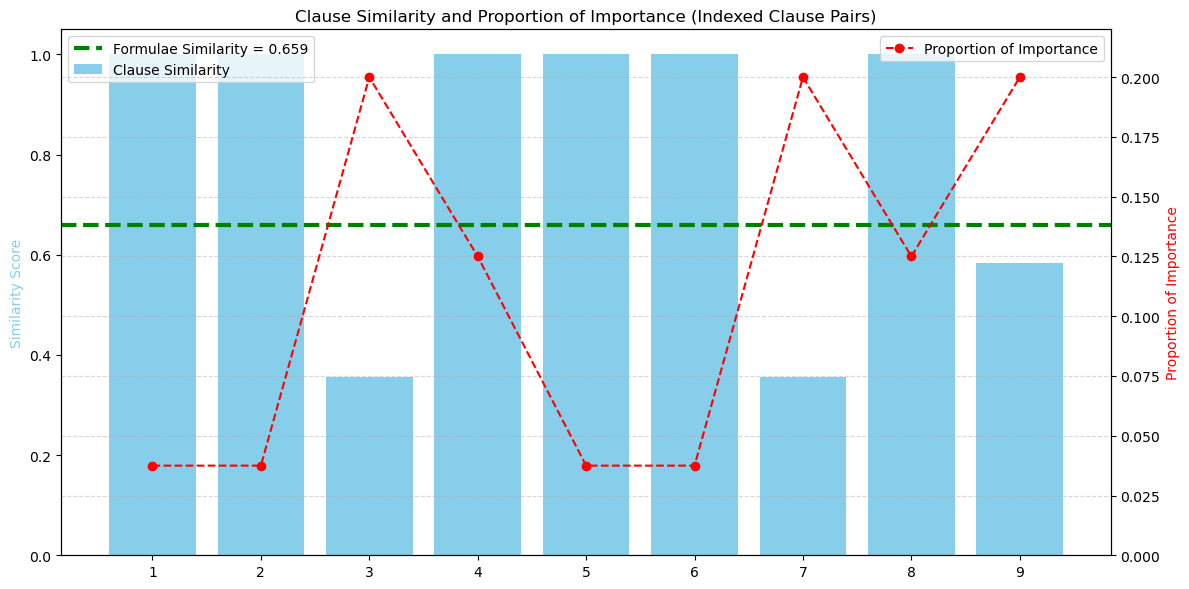

In [17]:
# --- Parameters ---
params = {
    "clause": {
        "alpha": 0.5,
        "beta": 0.5,
        "p": 1,
        "agg": agg_avg
    },
    "formula": {
        "alpha": 0.5,
        "beta": 0.5,
        "p": 1,
        "agg": agg_max
    }
}

# --- Flags of debug ---
debug_flags = {
    "literal": True,
    "clause": True,
    "formula": True
}

# --- Call of the similarity function ---
score, summary = simFormulaSet(
    F1=weighted_arg1_vs_arg2_premises["instances"],
    F2=weighted_arg2_vs_arg1_premises["instances"],
    clause_weights1=weighted_arg1_vs_arg2_premises["clause_weights"],
    clause_weights2=weighted_arg2_vs_arg1_premises["clause_weights"],
    predicate_weights1=weighted_arg1_vs_arg2_premises["predicate_weights"],
    predicate_weights2=weighted_arg2_vs_arg1_premises["predicate_weights"],
    constant_weights1=weighted_arg1_vs_arg2_premises["constant_weights"],
    constant_weights2=weighted_arg2_vs_arg1_premises["constant_weights"],
    params=params,
    debug=debug_flags
)

print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")
# --- Display of the summary ---
debug_flags["clause_weights1"] = weighted_arg1_vs_arg2_premises["clause_weights"]
debug_flags["clause_weights2"] = weighted_arg2_vs_arg1_premises["clause_weights"]

summarize_debug_output(summary, debug=debug_flags, top_n=9)
plot_weighted_clause_contributions(summary, x_labels="index") #x_labels="text"


🔷 FINAL SIMILARITY SCORE: 0.852

🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL LEVEL (Flat)
  → Total literal pairs (flat): 34
    1. ('AtLocation', ('Dog', 'Zoo')) ⇄ ('AtLocation', ('Dog', 'Zoo'))
       • predicate similarity: 1.000
       • parameter similarity : 1.000
       • literal similarity  : 1.000
    2. ('AtLocation', ('Monkey', 'Zoo')) ⇄ ('AtLocation', ('Monkey', 'Zoo'))
       • predicate similarity: 1.000
       • parameter similarity : 1.000
       • literal similarity  : 1.000
    3. ('¬Teasing', ('x', 'y')) ⇄ ('¬Teasing', ('x', 'y'))
       • predicate similarity: 1.000
       • parameter similarity : 1.000
       • literal similarity  : 1.000
    4. ('¬Teasing', ('y', 'x')) ⇄ ('¬Teasing', ('y', 'x'))
       • predicate similarity: 1.000
       • parameter similarity : 1.000
       • literal similarity  : 1.000
    5. ('Teasing', ('Dog', 'Monkey')) ⇄ ('Teasing', ('Dog', 'Monkey'))
       • predicate similarity: 1.000
       • parameter similarity : 1.000
       • lit

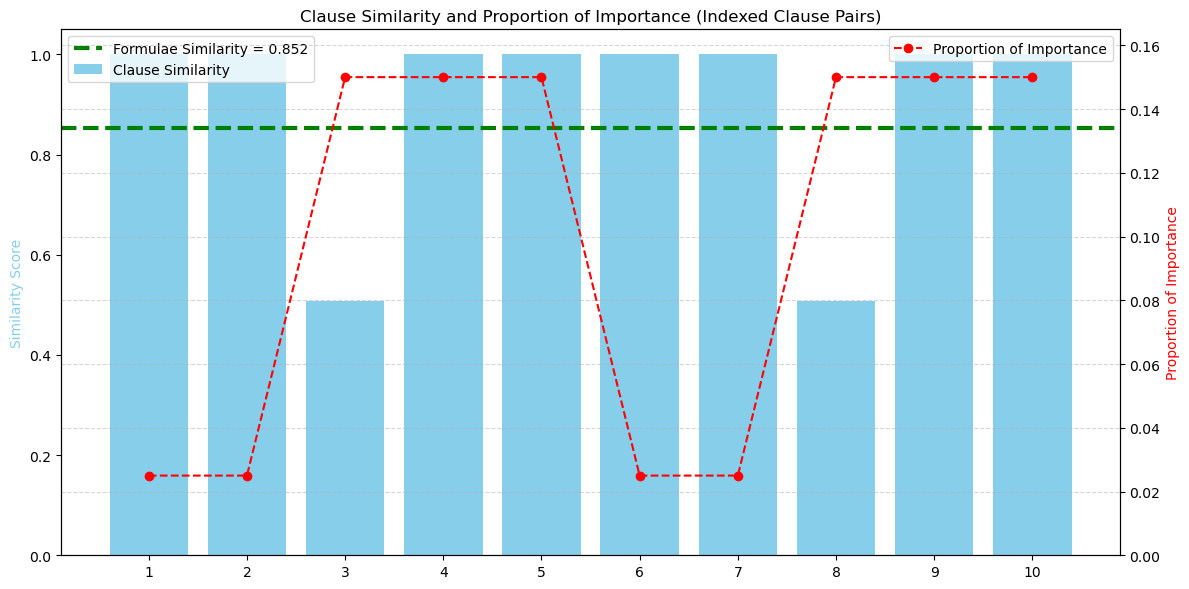

In [21]:
# --- Parameters ---
params = {
    "clause": {
        "alpha": 0.5,
        "beta": 0.5,
        "p": 1,
        "agg": agg_avg
    },
    "formula": {
        "alpha": 0.5,
        "beta": 0.5,
        "p": 1,
        "agg": agg_max
    }
}

# --- Flags of debug ---
debug_flags = {
    "literal": True,
    "clause": True,
    "formula": True
}

# --- Call of the similarity function ---
score, summary = simFormulaSet(
    F1=weighted_arg2_vs_arg3_premises["instances"],
    F2=weighted_arg3_vs_arg2_premises["instances"],
    clause_weights1=weighted_arg2_vs_arg3_premises["clause_weights"],
    clause_weights2=weighted_arg3_vs_arg2_premises["clause_weights"],
    predicate_weights1=weighted_arg2_vs_arg3_premises["predicate_weights"],
    predicate_weights2=weighted_arg3_vs_arg2_premises["predicate_weights"],
    constant_weights1=weighted_arg2_vs_arg3_premises["constant_weights"],
    constant_weights2=weighted_arg3_vs_arg2_premises["constant_weights"],
    params=params,
    debug=debug_flags
)

print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")
# --- Display of the summary ---
debug_flags["clause_weights1"] = weighted_arg2_vs_arg3_premises["clause_weights"]
debug_flags["clause_weights2"] = weighted_arg3_vs_arg2_premises["clause_weights"]

summarize_debug_output(summary, debug=debug_flags, top_n=9)
plot_weighted_clause_contributions(summary, x_labels="index") #x_labels="text"

## Evaluation of the Claims


🔷 FINAL SIMILARITY SCORE: 0.757

🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL LEVEL (Flat)
  → Total literal pairs (flat): 2
    1. ('Playful', ('Dog',)) ⇄ ('PlayfulInteraction', ('Dog', 'Monkey'))
       • predicate similarity: 0.881
       • parameter similarity : 0.964
       • literal similarity  : 0.923
    2. ('Dominant', ('Dog',)) ⇄ ('PlayfulInteraction', ('Dog', 'Monkey'))
       • predicate similarity: 0.267
       • parameter similarity : 0.964
       • literal similarity  : 0.616

📌 LITERAL LEVEL (Weighted)
  → Total literal pairs (weighted): 2

  1. ('Playful', ('Dog',)) ⇄ ('PlayfulInteraction', ('Dog', 'Monkey'))
     • predicate similarity        : 0.881
     • parameter similarity         : 0.964
     • final literal similarity    : 0.898

  2. ('Dominant', ('Dog',)) ⇄ ('PlayfulInteraction', ('Dog', 'Monkey'))
     • predicate similarity        : 0.267
     • parameter similarity         : 0.964
     • final literal similarity    : 0.410

📌 CLAUSE LEVEL (Flat)
  → Tota

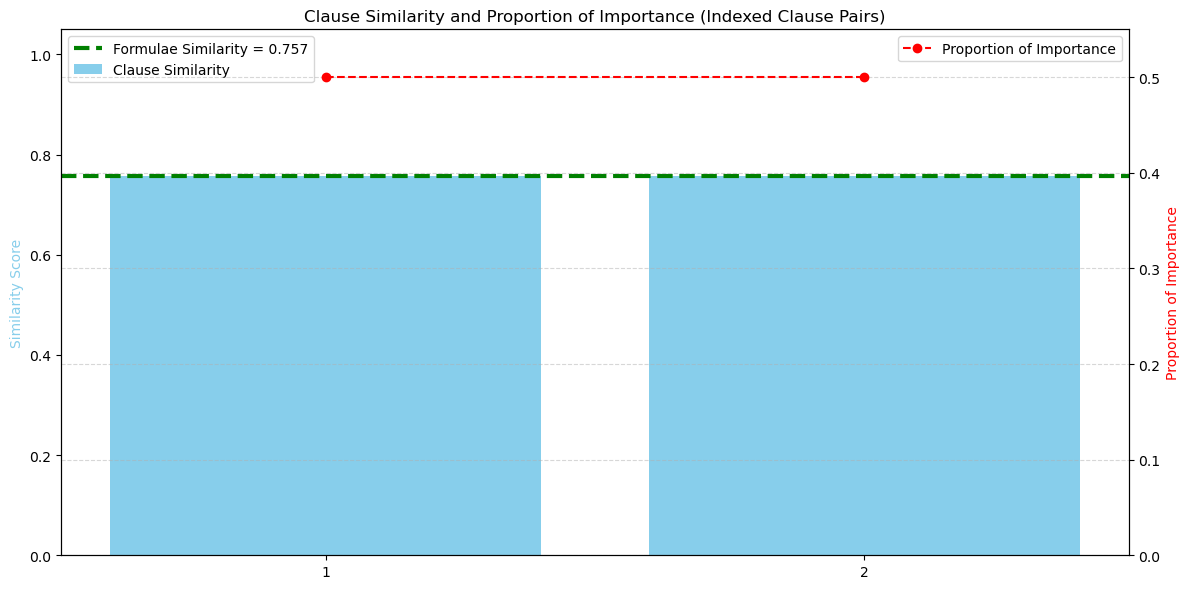

In [22]:
# --- Parameters ---
params = {
    "clause": {
        "alpha": 0.5,
        "beta": 0.5,
        "p": 1,
        "agg": agg_avg
    },
    "formula": {
        "alpha": 0.5,
        "beta": 0.5,
        "p": 1,
        "agg": agg_max
    }
}

# --- Flags of debug ---
debug_flags = {
    "literal": True,
    "clause": True,
    "formula": True
}

# --- Call of the similarity function ---
score, summary = simFormulaSet(
    F1=weighted_arg1_vs_arg2_claim["instances"],
    F2=weighted_arg2_vs_arg1_claim["instances"],
    clause_weights1=weighted_arg1_vs_arg2_claim["clause_weights"],
    clause_weights2=weighted_arg2_vs_arg1_claim["clause_weights"],
    predicate_weights1=weighted_arg1_vs_arg2_claim["predicate_weights"],
    predicate_weights2=weighted_arg2_vs_arg1_claim["predicate_weights"],
    constant_weights1=weighted_arg1_vs_arg2_claim["constant_weights"],
    constant_weights2=weighted_arg2_vs_arg1_claim["constant_weights"],
    params=params,
    debug=debug_flags
)

print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")
# --- Display of the summary ---
debug_flags["clause_weights1"] = weighted_arg1_vs_arg2_claim["clause_weights"]
debug_flags["clause_weights2"] = weighted_arg2_vs_arg1_claim["clause_weights"]

summarize_debug_output(summary, debug=debug_flags, top_n=9)
plot_weighted_clause_contributions(summary, x_labels="index") #x_labels="index"


🔷 FINAL SIMILARITY SCORE: 0.653

🔍 SUMMARY OF SIMILARITY COMPARISON

📌 LITERAL LEVEL (Flat)
  → Total literal pairs (flat): 1
    1. ('PlayfulInteraction', ('Dog', 'Monkey')) ⇄ ('SocialConflict', ('Dog', 'Monkey'))
       • predicate similarity: 0.261
       • parameter similarity : 1.000
       • literal similarity  : 0.630

📌 LITERAL LEVEL (Weighted)
  → Total literal pairs (weighted): 1

  1. ('PlayfulInteraction', ('Dog', 'Monkey')) ⇄ ('SocialConflict', ('Dog', 'Monkey'))
     • predicate similarity        : 0.261
     • parameter similarity         : 1.000
     • final literal similarity    : 0.305

📌 CLAUSE LEVEL (Flat)
  → Total clause pairs compared (flat): 1
    1. Clause 1: frozenset({('PlayfulInteraction', ('Dog', 'Monkey'))})
         Clause 2: frozenset({('SocialConflict', ('Dog', 'Monkey'))})
         → Clause similarity: 0.630

📌 CLAUSE LEVEL (Weighted)
  → Total clause pairs (weighted best matches): 2

  1. Clause pair:
       Clause 1: frozenset({('PlayfulInteraction'

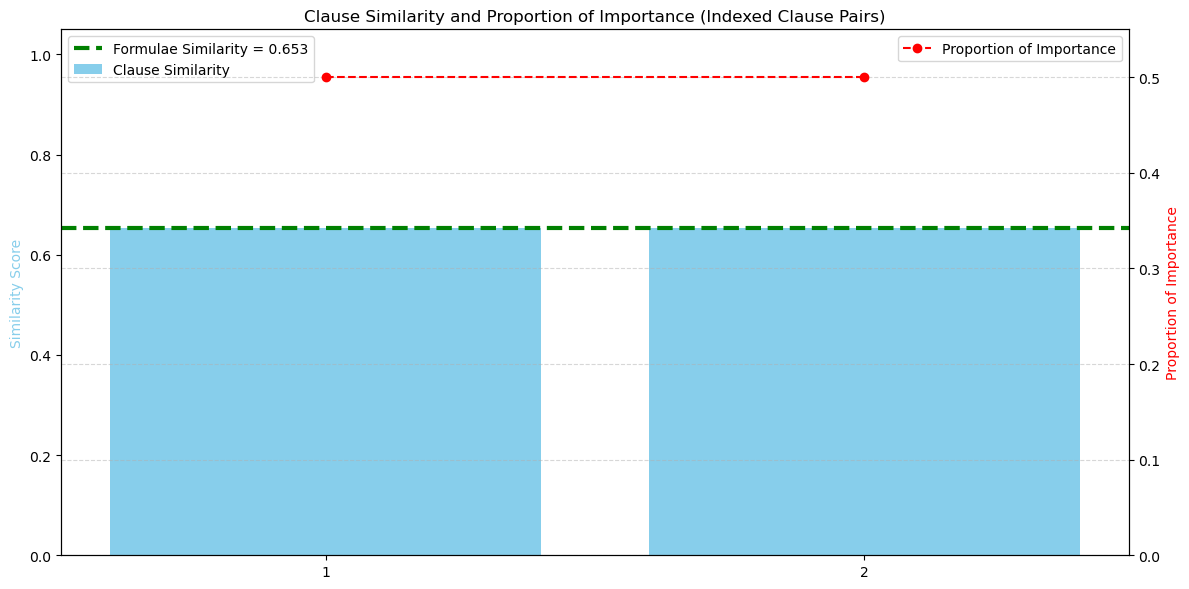

In [23]:
# --- Parameters ---
params = {
    "clause": {
        "alpha": 0.5,
        "beta": 0.5,
        "p": 1,
        "agg": agg_avg
    },
    "formula": {
        "alpha": 0.5,
        "beta": 0.5,
        "p": 1,
        "agg": agg_max
    }
}

# --- Flags of debug ---
debug_flags = {
    "literal": True,
    "clause": True,
    "formula": True
}

# --- Call of the similarity function ---
score, summary = simFormulaSet(
    F1=weighted_arg2_vs_arg3_claim["instances"],
    F2=weighted_arg3_vs_arg2_claim["instances"],
    clause_weights1=weighted_arg2_vs_arg3_claim["clause_weights"],
    clause_weights2=weighted_arg3_vs_arg2_claim["clause_weights"],
    predicate_weights1=weighted_arg2_vs_arg3_claim["predicate_weights"],
    predicate_weights2=weighted_arg3_vs_arg2_claim["predicate_weights"],
    constant_weights1=weighted_arg2_vs_arg3_claim["constant_weights"],
    constant_weights2=weighted_arg3_vs_arg2_claim["constant_weights"],
    params=params,
    debug=debug_flags
)

print(f"\n🔷 FINAL SIMILARITY SCORE: {score:.3f}")
# --- Display of the summary ---
debug_flags["clause_weights1"] = weighted_arg2_vs_arg3_claim["clause_weights"]
debug_flags["clause_weights2"] = weighted_arg3_vs_arg2_claim["clause_weights"]

summarize_debug_output(summary, debug=debug_flags, top_n=9)
plot_weighted_clause_contributions(summary, x_labels="index") #x_labels="text"

## Evaluations of the Arguments (1,2) vs (2,3)


Similarity Arg1, Arg2 : 

- 0.5 * 0.659 + 0.5 * 0.757 = 0.708

- 0.2 * 0.659 + 0.8 * 0.757 = 0.7374

Similarity Arg2, Arg3 : 

- 0.5 * 0.852 + 0.5 * 0.653 = 0.7525

- 0.2 * 0.852 + 0.8 * 0.653 = 0.6928